In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from src.assoc_utils_np import *
from src.theory_utils import *
from src.data_utils import *
from src.assoc_utils_np_2D import gen_gbook_2d
plt.style.use('./src/presentation.mplstyle')


In [2]:
lambdas = [3,4,5]                  # module period (linear dimension)
m = len(lambdas)
Ng = np.sum(np.square(lambdas))                           # num grid cells
# Np_lst=np.arange(25,350,250)
Np_lst=[25,350]
pflip = 0.                      # param controling injected noise
Niter = 2                         # number of iterations for scaffold dynamics
Npos = np.prod(lambdas)**2
nruns = 1  # number of runs you want to average the results over
Npatts_lst = np.arange(1,Npos+1,100)


In [3]:
## Choose ordering used to make gbook: 
#optimal generalization/rank ordered corresponds to ordering used in the proof for fastest generalization
#Spiral is a spiraling outward contiguous region of the grid coding space
#Hairpin is a row-by-row covering of the grid space

## optimal generalization gbook (is also rank ordered)
print('optimal gbook')
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)#10000)#


### hairpin gbook
# print('hairpin gbook')
# gbook = gen_gbook_2d(lambdas, Ng, np.prod(lambdas))
# gbook = gbook.reshape(Ng, np.prod(lambdas)**2)


## spiral gbook
# print('spiral gbook')
# gbook_hp = gen_gbook_2d(lambdas, Ng, np.prod(lambdas))
# gbook_hp = gbook_hp.reshape(Ng, np.prod(lambdas)**2)
# x,y=make_spiral(np.prod(lambdas))
# locs1=np.prod(lambdas)*y+x
# gbook = gbook_hp[:,locs1]

optimal gbook


In [8]:
##Choose experiment to run

#Base case
err_gcpc, num_correct = capacity_gcpc_vectorized(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst,test_generalization='no')

#Place states chosen to be random vectors with same sparsity as base case (teal curves in Fig. 2)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)

#Randomly shuffled ordering (shuffles order irrespective of which gbook ordering chosen above)
# err_gcpc, num_correct = capacity_gcpc_shuffled(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)

#Two different ways of doing fixed-random connections from hippocampal cells to grid cells (only relevant to blue and red curves (resp) in SI Fig. S4)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p_both_random(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p_both_random_2(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.23it/s]


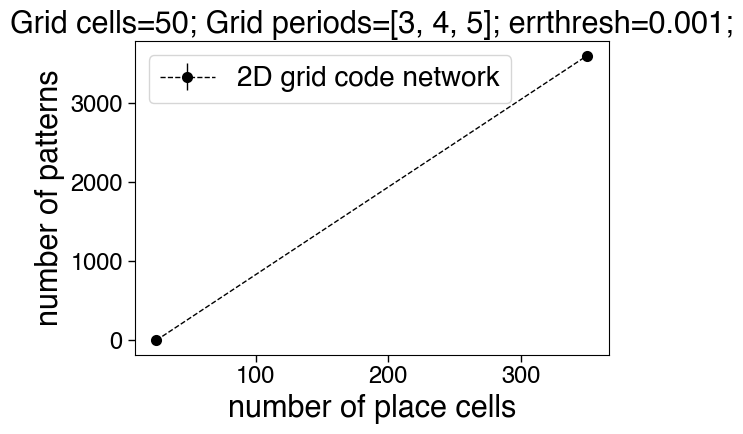

In [5]:
##Compute capacity across values of Np. This particular code designed assuming typical capacity estimation
## Does not work if generalization is being tested. Use the cell below if generalization is being tested

errthresh = 0.001 #Some tiny nonzero value above possible floating point error

capacity = -1*np.ones((len(Np_lst), nruns))
valid = err_gcpc <= errthresh   # bool
for Np in range(len(Np_lst)):
    # Original conservative
    for r in range(nruns):
      lst = np.argwhere(valid[Np,:,r] == False)
      #lst = np.argwhere(valid[Np,:] == False)
      if len(lst) == 0:
        #print("full capacity")
        capacity[Np,r] = Npos
      else:      
        bef_err = lst[0]-1
        bef_err = bef_err*(bef_err>0)  #Don't want to return -1 if lst[0]=0
        capacity[Np,r] = Npatts_lst[bef_err]

avg_cap = np.mean(capacity, axis=1)   # mean error over runs
#std_cap = stats.sem(capacity, axis=1)    # std dev over runs
std_cap = np.std(capacity, axis=1)    # std dev over runs



fig, ax = plt.subplots()
ax.errorbar(Np_lst, avg_cap, yerr=std_cap, fmt='ko--', label='2D grid code network')
add_labels(ax, f"Grid cells={Ng}; Grid periods={lambdas}; errthresh={errthresh};", "number of place cells", "number of patterns")
# savefig(fig, ax, f"{results_dir}/{filename}")
plt.show()


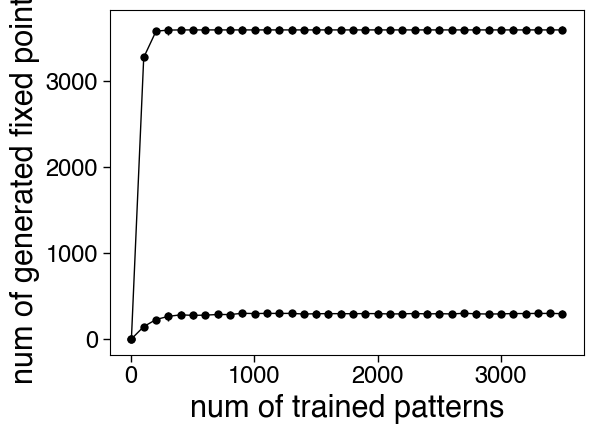

In [9]:
#When computing capacity for generalization plot, can simply plot mean and std of num_correct as below. 
#Make sure to pass test_generalization='yes' if doing this!

[plt.errorbar(x=Npatts_lst,y=num_correct[i].mean(axis=1),yerr=num_correct[0].std(axis=1),label='Np='+str(Np_lst[i]), marker='o',mew=0) for i in range(len(Np_lst))]
plt.xlabel('num of trained patterns')
plt.ylabel('num of generated fixed points')
plt.show()


thresh=0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.93s/it]


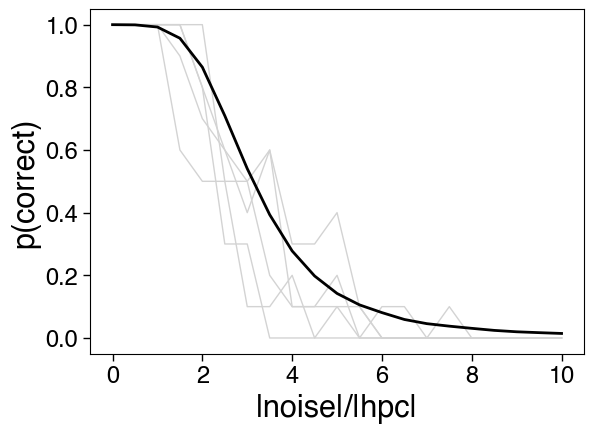

In [39]:
#Barebones code to examine basin sizes

lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
Npos = Npos*Npos
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)
nruns=1
Np = 400

Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh=0.5

print('thresh='+str(thresh))
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # (nruns, Np, Npos)
Wgp = train_gcpc(pbook, gbook, Npos)

mean_p_norm = np.mean(np.linalg.norm(pbook,axis=1))
noise_vals = np.arange(0,10.5,0.5)
basin_runs = 100
correct = np.zeros((basin_runs,len(noise_vals),Npos))
for bidx in tqdm(range(basin_runs)):
    # noise =  np.random.normal(0,1,pbook.shape)/np.sqrt(Np)
    for nidx,noise_val in enumerate((noise_vals)):
        noise = np.random.normal(0,1,pbook.shape)/np.sqrt(Np)
        pinit = pbook + noise_val*noise*mean_p_norm
        gin = Wgp@pinit
        g = gridCAN_2d(gin,lambdas)
        p = nonlin(Wpg@g, thresh)
        
        
        err = np.linalg.norm(p - pbook,axis=1)
        correct[bidx,nidx] = err.squeeze()#<1e-6
     
correct_valid = correct<1e-6
correct_per_pat = correct_valid.mean(axis=0)

[plt.plot(noise_vals,correct_per_pat[:,i],color='lightgray') for i in np.random.randint(0,Npos,5)];
plt.plot(noise_vals,correct_per_pat.mean(axis=1),'k',lw=2.);
plt.xlabel(r'|noise|/|hpc|');
plt.ylabel('p(correct)');
# plt.title('Npatts = '+str(Npatts))
# plt.xlim(0,0.5)
# plt.ylim(0,1)
# plt.savefig('s_basin_cdf_Npatts_'+str(Npatts)+'.pdf')